<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2020_0724vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 簡単な変分自己符号化モデルのデモ

- date: 2020-0724
- author: 浅川 伸一
- reference: 
    - Kingma and Wellings (2014), [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
    - Kingma and Welling, (2019) [An Introduction to Variational Autoencoders](https://arxiv.org/pdf/1906.02691.pdf) 


In [ ]:
# このセルは実行しないで良いです。ハーバード大大学院生たちの ELBO についてのおふざけ動画です
# もちろん，肘を表す英単語 elbow と，変分下限 ELBO: Evidence Lower BOund とは同じ発音なので
from IPython.display import YouTubeVideo, display
youtube_id = 'jugUBL4rEIM'
display(YouTubeVideo(youtube_id, width=600, height=480))

In [1]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

seed = 42
torch.manual_seed(seed)

In [4]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', 
                   train=True, 
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', 
                   train=False, 
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True,)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [7]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [8]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [9]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [10]:
if not os.path.exists('results'):
    os.mkdir('results')

In [13]:
epochs = 30
log_interval = 1000
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28), 'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 108.964584
====> Epoch: 1 Average loss: 106.6091
====> Test set loss: 106.1576
Train Epoch: 2 [0/60000 (0%)]	Loss: 108.421814
====> Epoch: 2 Average loss: 106.1209
====> Test set loss: 105.6119
Train Epoch: 3 [0/60000 (0%)]	Loss: 110.899719
====> Epoch: 3 Average loss: 105.6826
====> Test set loss: 105.3344
Train Epoch: 4 [0/60000 (0%)]	Loss: 105.745026
====> Epoch: 4 Average loss: 105.3982
====> Test set loss: 105.2125
Train Epoch: 5 [0/60000 (0%)]	Loss: 108.553146
====> Epoch: 5 Average loss: 105.1546
====> Test set loss: 104.6012
Train Epoch: 6 [0/60000 (0%)]	Loss: 102.237633
====> Epoch: 6 Average loss: 104.9078
====> Test set loss: 105.1303
Train Epoch: 7 [0/60000 (0%)]	Loss: 104.325768
====> Epoch: 7 Average loss: 104.6284
====> Test set loss: 104.2933
Train Epoch: 8 [0/60000 (0%)]	Loss: 104.935333
====> Epoch: 8 Average loss: 104.4719
====> Test set loss: 104.2108
Train Epoch: 9 [0/60000 (0%)]	Loss: 103.903336
====> Epoch: 9 Average loss: 104.

In [14]:
!ls results

reconstruction_1.png  reconstruction_28.png sample_19.png
reconstruction_10.png reconstruction_29.png sample_2.png
reconstruction_11.png reconstruction_3.png  sample_20.png
reconstruction_12.png reconstruction_30.png sample_21.png
reconstruction_13.png reconstruction_4.png  sample_22.png
reconstruction_14.png reconstruction_5.png  sample_23.png
reconstruction_15.png reconstruction_6.png  sample_24.png
reconstruction_16.png reconstruction_7.png  sample_25.png
reconstruction_17.png reconstruction_8.png  sample_26.png
reconstruction_18.png reconstruction_9.png  sample_27.png
reconstruction_19.png sample_1.png          sample_28.png
reconstruction_2.png  sample_10.png         sample_29.png
reconstruction_20.png sample_11.png         sample_3.png
reconstruction_21.png sample_12.png         sample_30.png
reconstruction_22.png sample_13.png         sample_4.png
reconstruction_23.png sample_14.png         sample_5.png
reconstruction_24.png sample_15.png         sample_6.png
reconstruction_25.p

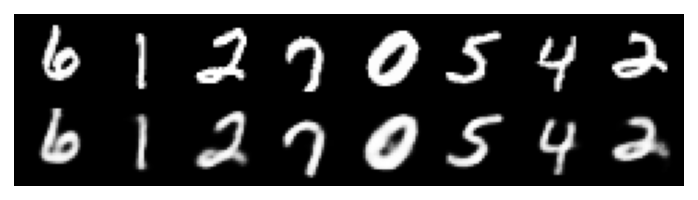

In [15]:
import PIL.Image as PILImage
import matplotlib.pyplot as plt

img = PILImage.open('results/reconstruction_2.png')
plt.axis(False); plt.imshow(img); plt.show()

